In [1]:
import sys
sys.path.append("..")
import lib.data as data
import lib.haar_wawelet_method.gradients as grad
import numpy as np
import lib.haar_wawelet_method.util as ut
from lib.mesurements import mse

In [2]:
import numpy as np
import lib.haar_wawelet_method.gradients as grad
import lib.data as data
import matplotlib.pyplot as plt
import lib.mesurements
import lib.haar_wawelet_method.haar as haar
%matplotlib inline

$\lambda_k = \frac{4}{h^2}\sin^{2}(\frac{kh}{2})$

In [3]:
def get_lamda (N,h):
    return np.array([4 / h**2 * np.sin(k * h / 2)**2 for k in range (N)])

$\mu_k = 1 - \frac{h^2}{6}\lambda_k$

In [4]:
def get_mu (N,h):
    return 1 - h**2 / 6 * get_lamda(N,h)

In [5]:
def create_L(dim):
    diag1 = np.array([2 if i == j else 0 for i in range (dim) for j in range(dim)]).reshape(dim,dim)
    diag2 = np.array([-1 if np.abs(i - j) == 1 else 0 for i in range (dim) for j in range(dim)]).reshape(dim,dim)
    return diag1 + diag2

In [6]:
def create_B(dim):
    return np.eye(dim) - 1 / 6 * create_L(dim)

In [7]:
def create_G1(dim):
    diag1 = np.array([-1 if i - j == -1 else 0 for i in range (dim) for j in range(dim)]).reshape(dim,dim)
    diag2 = np.array([1 if i - j == 1 else 0 for i in range (dim) for j in range(dim)]).reshape(dim,dim)
    return 0.5 * (diag1 + diag2)

In [8]:
def create_G2(dim):
    return create_G1(dim).T

добавить выбросы?

G2=G1';
G1g1=zeros(N,N);
g2G2=zeros(N,N);
for i=1:N
    G1g1(:,i)=G1*g1(:,i);
    g2G2(:,i)=g2*G2(:,i);
end;

for i=1:N
    G1(:,i)=G1g1*B(:,i);
    G2(:,i)=B*g2G2(:,i);
end;

F=G1+G2;
% F=-F;
F1=fft(F);
%subplot(3,2,1), mesh(y,x,F1), title('Ishodnaya'), xlabel('y'), ylabel('x');
F2=fft(F1');
sv1=zeros(1,N);
sv2=zeros(1,N);
for k=1:N
    sv1(k)=((sin((k-1)*h/2))^2)*4/(h^2);
    sv2(k)=1-(h^2)*sv1(k)/6;
end;
A1=skm(x,y,N,z);
[A2,PVi]=sko(x,y,N,z);
F21=F2;
mm=zeros(1,kkk);
ms=zeros(1,kkk);
for i=1:kkk
    for k=1:N
        for l=1:N
            t=sv1(k)*sv2(l)+sv1(l)*sv2(k)+sv2(k)*sv2(l)*alpha(i);
            F21(k,l)=F2(k,l)/t;
        end;
    end;
    F3=ifft(F21);
    Fv=ifft(F3');
    Fv=real(Fv);
    [A3,PVv]=sko(x,y,N,Fv);
    A4=skm(x,y,N,Fv);
    Ps=Fv*A2/A3-z;
    Pm=Fv*A1/A4-z;
    mm(i)=skm(x,y,N,Pm)/A1*100;
    [A5,PVp]=sko(x,y,N,Ps);
    ms(i)=A5/A2*100;
end;

In [9]:
def get_F(g1, g2, h):
    size = g1.shape[0]
    #как в теории
#     mat1 = np.dot(create_B(size), create_G1(size))/h
#     F1 = np.dot(mat1, g1)
#     mat2 = np.dot(create_B(size), create_G2(size))/h
#     F2 = np.dot(mat2, g2)
#вариант 2
    mat1 = np.dot(create_G1(size)/h, g1)
    F1 = np.dot(mat1, create_B(size))
    mat2 = np.dot(create_B(size), g2)/h
    F2 = np.dot(mat2, create_G2(size))
    return F1 + F2

Почему-то если умножать так $G_1g_1B + Bg_2G_2$ то метод работает для функций $x^{2k+1} + y^{2k+1}$

In [51]:
def super_gauss(x, y, a, N):
    return np.exp(-((x**2 + y**2) / a**2) ** N)
    #return np.exp(-((x**2 + y**2) / 2.88 * np.pi) ** 10)

In [112]:
def method(g1, g2, alfa, gamma, h):
    f = np.fft.fft2(get_F(g1, g2, h))
    #f = np.fft.fft2(np.conj(f))
    #cдвиг
    #f = np.fft.fftshift(f)
    lamda = get_lamda(f.shape[0], h)
    mu = get_mu(f.shape[0], h)
    res = np.zeros(f.shape, dtype=complex)
    for k in range(res.shape[0]):
        for l in range(res.shape[1]):
            res[k,l] = (lamda[k]*mu[l] + mu[k]*lamda[l] + alfa * mu[k]*mu[l] + gamma * lamda[k]*lamda[l])
    #res = np.fft.ifftshift(res)
    res = np.fft.ifft2(f/res)
    return np.real(res)
    
    #return np.real(np.fft.ifft2((np.conj(res))))

In [113]:
def disk(x, y, value, r):
    return value * (x**2 + y**2 < r**2 + 1)

какими брать g1, g2?
делать ли преобразование фурье?


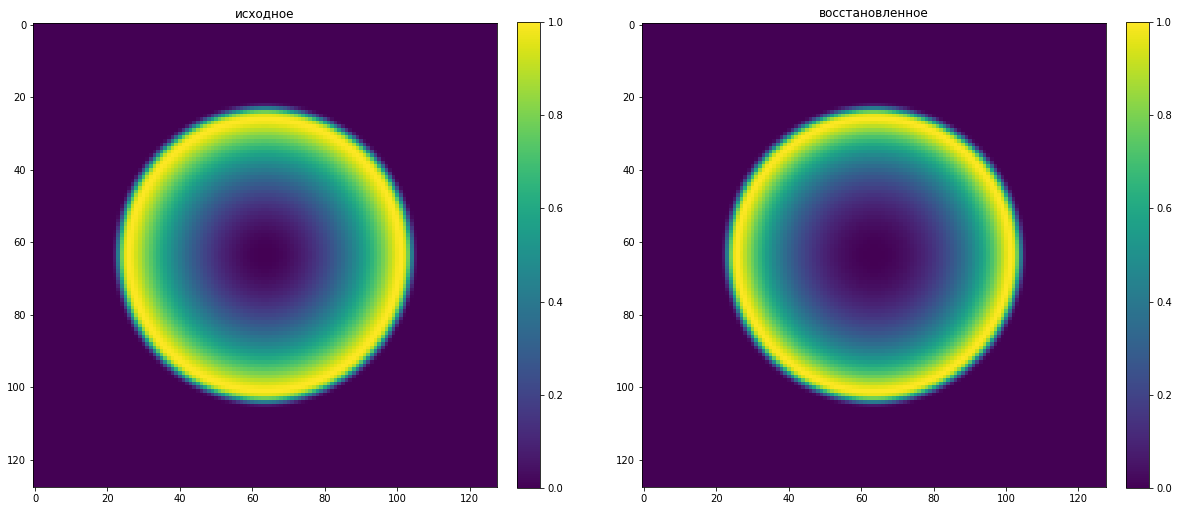

In [192]:
M = 7
#должно быть так ! исправь баг!
y, x = data.get_plane(-np.pi, np.pi, -np.pi, np.pi, M)

#y, x = data.get_plane(0, 2 * np.pi, 0, 2 * np.pi, M)
h = 2*np.pi / 2**M
im = x ** 2 + y ** 2
gauss = super_gauss(x, y, 2, 20)
im *= gauss
g1, g2 = 2 * x,  2 * y
g1 *= gauss
g2 *= gauss

# g1, g2 = grad.Hudgin_gradien_model(im)
# g1 /= h
# g2 /= h

fig, axes = plt.subplots(1,2, figsize = (20,10))
restored = method(g1,g2, 2, 0.001, h)
#нормировка исходного
im -= im.min()
im /= im.max()
#нормировка полученного
restored -= restored.min()
restored *= gauss
restored /= restored.max()

img1 = axes[0].imshow(im)
img2 = axes[1].imshow((restored))
axes[0].set_title('исходное')
axes[1].set_title('восстановленное')
fig.colorbar(img1, ax = axes[0],fraction=0.046, pad=0.04)
fig.colorbar(img2, ax = axes[1],fraction=0.046, pad=0.04)
#fig.savefig('variational_very_bad.png')

In [167]:
mse(im,method(g1,g2, 3, 0.001, h))


0.00794013355751893

In [165]:
mse(im,method(g1,g2, 1, 2, h))

0.011480808203244383